### Baseline Classifier
We want to find a way to estimate confluence wihtout machine learning
Herefore we try different image processing methods. The following graphic gives an overview:



For our cell images, we think that that the following methods could be the must suitable:
- Threshold Methods
- Edged based Methods

#### Imports and variables 

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
import skimage.io as io
from skimage.filters import threshold_multiotsu, threshold_mean
import os

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
img_dir = "./data/LC_GENERALPREP_LAZY/01preprocessed/1280_960/"
imgs = os.listdir(img_dir)


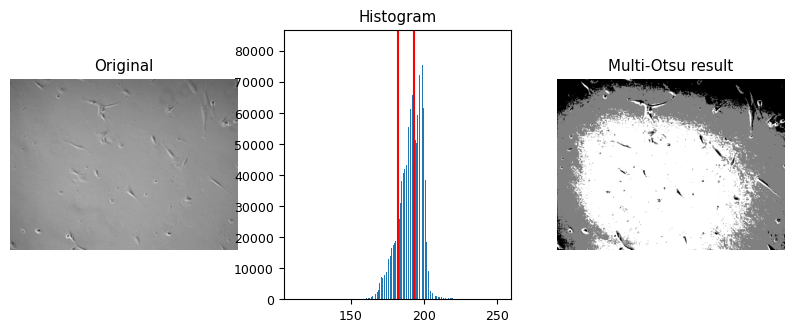

In [7]:
imagepath = imgs[0]
image = io.imread(os.path.join(img_dir, imagepath), as_gray=True)
# read image with skimage

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds_otus = threshold_multiotsu(image)
thresholds_mean = threshold_mean(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds_otus)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds_otus:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='gray')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()


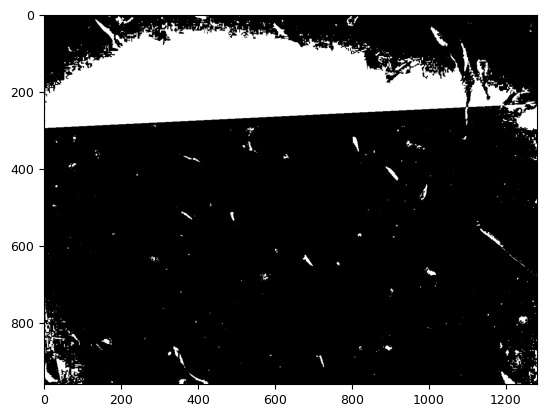

In [10]:
from skimage import measure

# Find contours in the regions
contours = measure.find_contours(regions, 0.5)

# Create an empty mask
mask = np.zeros_like(image, dtype=np.uint8)

# Draw the contours on the mask
for contour in contours:
    contour = np.round(contour).astype(int)
    mask[contour[:, 0], contour[:, 1]] = 1

# Show the mask
plt.imshow(mask, cmap='gray')
plt.title('Object Mask')
plt.axis('off')
plt.show()
# fill polygons in mask

mask = np.zeros_like(image, dtype=np.uint8)
for contour in contours:
    rr, cc = draw.polygon(contour[:, 0], contour[:, 1])
    mask[rr, cc] = 1
# Show the mask
plt.imshow(mask, cmap='gray')


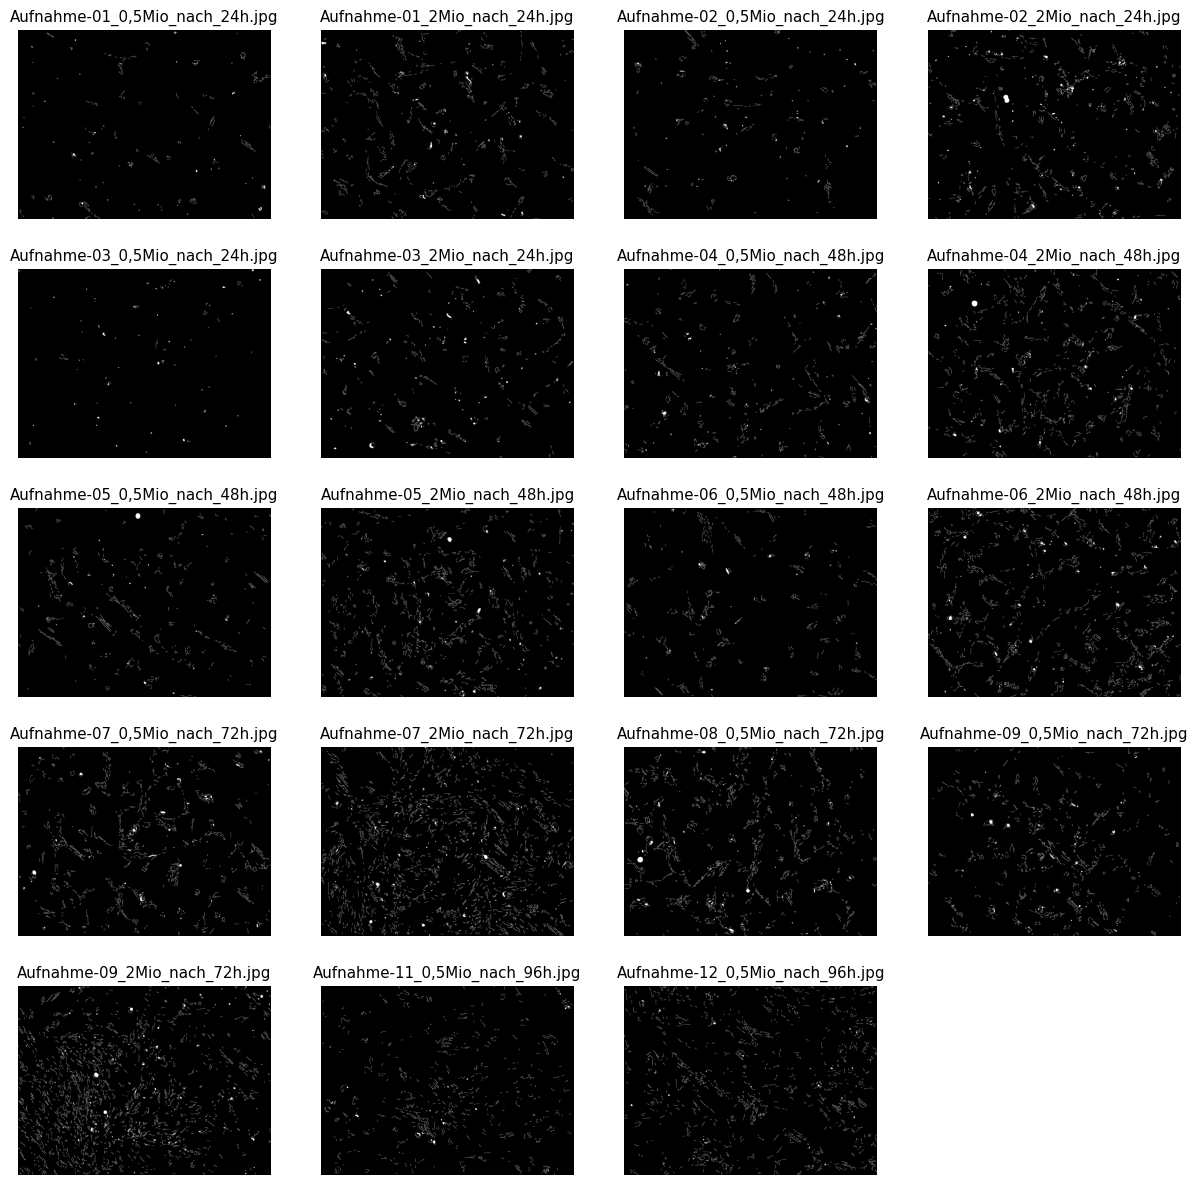

In [27]:
def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

In [46]:
close_contour(contours[0])
print(f'shape of contour: {contours[0].shape}')

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

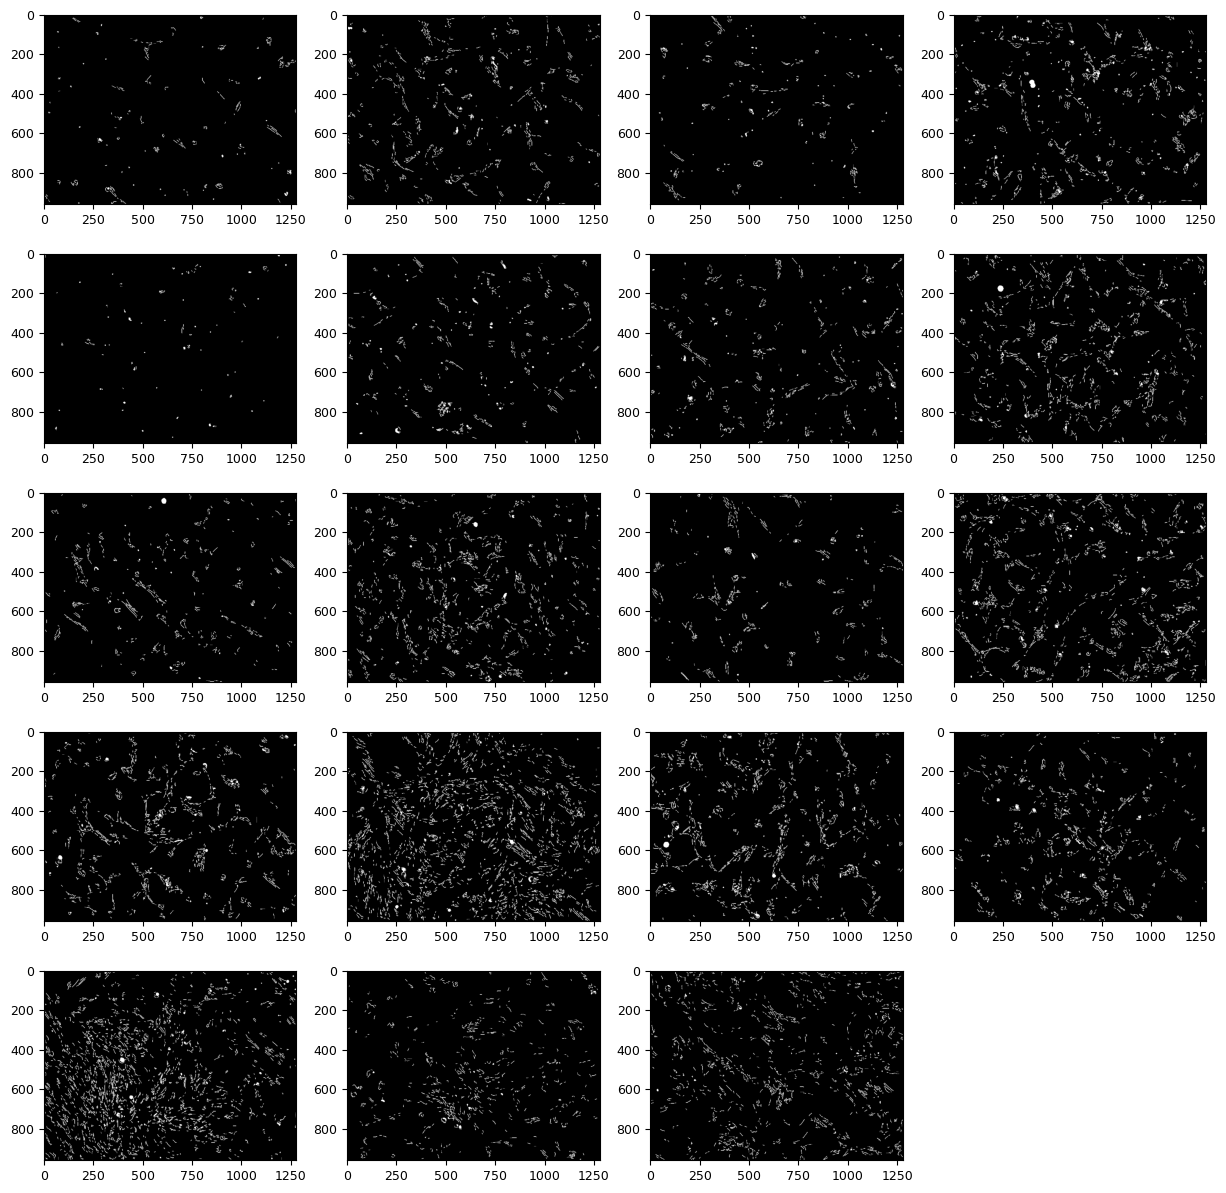

In [56]:
#use this!!!
"""
skimage.measure.find_contours(image, level=None, fully_connected='low', positive_orientation='low', *, mask=None)[source]
Find iso-valued contours in a 2D array for a given level value.
https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.find_contours
Uses the “marching squares” method to compute a the iso-valued contours of the input 2D array for a particular level value. Array values are linearly interpolated to provide better precision for the output contours.
"""

from skimage import morphology
from skimage.feature import canny
from scipy import ndimage as ndi
nrows = 5
ncols = len(imgs) // nrows + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
cleaned_imgs = []
for i, ax in enumerate(axes.flatten()):
    if i >= len(imgs):
        ax.axis('off')
        continue
    image = io.imread(os.path.join(img_dir, imgs[i]), as_gray=True)
    edges = canny(image)
    filled = ndi.binary_fill_holes(input=edges)
    cleaned = morphology.remove_small_objects(filled, 10)
    cleaned_imgs.append(cleaned)
    ax.imshow(cleaned, cmap='gray')
    ax.axis('off')
    ax.set_title(imgs[i])

from skimage import measure
from skimage.segmentation import clear_border, flood, flood_fill
import cv2
masks = []
import skimage
nrows = 5
ncols = len(imgs) // nrows + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    if i >= len(imgs):
        ax.axis('off')
        continue
    image = cleaned_imgs[i]
    contours = measure.find_contours(image, 0.5)
    closed_contours = [measure.approximate_polygon(close_contour(contour), tolerance=0) for contour in contours]
    # draw the contours on the image
    mask = np.zeros_like(image, dtype=np.uint8)
    for contour in closed_contours:
        contour = np.round(contour).astype(int)
        rr, cc = draw.polygon(contour[:, 0], contour[:, 1])
        mask[rr, cc] = 255
    # use neares interpolation to fill the black pixels between the white masks also white
    masks.append(mask)
    mask_interpolated = skimage.transform.resize(mask, (image.shape[0], image.shape[1]), order=0, mode='constant', anti_aliasing=False)
    ax.imshow(mask_interpolated, cmap='gray')

In [52]:
from skimage.segmentation import random_walker
markers = np.zeros_like(image, dtype=np.uint)
markers[image < 0] = 1
markers[image > 0] = 2
labels = random_walker(image, markers, beta=10, mode='bf')
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(labels, cmap='gray')
ax[1].set_title('Segmentation')
for a in ax:
    a.axis('off')

In [53]:
import numpy as np
import cv2

def remove_noise(gray, num):
    Y, X = gray.shape
    nearest_neigbours = [[
        np.argmax(
            np.bincount(
                gray[max(i - num, 0):min(i + num, Y), max(j - num, 0):min(j + num, X)].ravel()))
        for j in range(X)] for i in range(Y)]
    result = np.array(nearest_neigbours, dtype=np.uint8)
    # cv2.imwrite('result2.jpg', result)
    return result

In [54]:
mask = masks[0]
mask.shape

(960, 1280)

In [64]:
result = remove_noise(mask, 2)
plt.imshow(result, cmap='gray')

In [62]:
mask = masks[0]
import cv2
import numpy as np

# Load the binary semantic segmentation mask
# mask = cv2.imread('your_mask_image.png', cv2.IMREAD_GRAYSCALE)

# Invert the mask (background becomes white)
mask_inverse = cv2.bitwise_not(mask)

# Perform a flood fill from the top-left corner to fill the holes
lo_diff = 20000  # Lower brightness/color difference threshold
up_diff = 20000  
h, w = mask_inverse.shape[:2]
fill_mask = np.zeros((h + 2, w + 2), dtype=np.uint8)
cv2.floodFill(mask_inverse, fill_mask, (100, 100), 255, (lo_diff, lo_diff, lo_diff), (up_diff, up_diff, up_diff), cv2.FLOODFILL_MASK_ONLY)

# Invert the filled mask back
filled_mask = cv2.bitwise_not(mask_inverse)
plt.imshow(filled_mask, cmap='gray')

### Make script of best method

In [2]:
import os
os.getcwd()

'/home/sc.uni-leipzig.de/me792rqay/development/confluence/notebooks'

In [3]:

os.getcwd()
os.chdir("..")

In [13]:

"""
skimage.measure.find_contours(image, level=None, fully_connected='low', positive_orientation='low', *, mask=None)[source]
Find iso-valued contours in a 2D array for a given level value.
https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.find_contours
Uses the “marching squares” method to compute a the iso-valued contours of the input 2D array for a particular level value. Array values are linearly interpolated to provide better precision for the output contours.
"""

import glob
from skimage import draw
from skimage import morphology
from skimage.feature import canny
from scipy import ndimage as ndi
import os
import skimage.io as io
from skimage import measure
from skimage.segmentation import clear_border, flood, flood_fill
import cv2
import skimage
from skimage.color import rgb2gray
import numpy as np
import subprocess
import matplotlib.pyplot as plt


def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour
def save_mask(id_key, path, mask):
    fullpath = os.path.join(id_key, "preds")
    if not os.path.exists(fullpath):
        os.makedirs(fullpath, exist_ok=True)
    path = path.replace(".jpg","_mask.png")
    io.imsave(os.path.join(fullpath, path), mask)
    
def baseline(id_key, images):
    masks = []
    paths = images[1]
    images = images[0]

    for image, path in zip(images, paths):
        
        edges = canny(image)
        filled = ndi.binary_fill_holes(input=edges)
        image = morphology.remove_small_objects(filled, 10)
 
        contours = measure.find_contours(image, 0.5)
        closed_contours = [measure.approximate_polygon(close_contour(contour), tolerance=0) for contour in contours]
        # draw the contours on the image
        mask = np.zeros_like(image, dtype=np.uint8)
        for contour in closed_contours:
            contour = np.round(contour).astype(int)
            rr, cc = draw.polygon(contour[:, 0], contour[:, 1])
            mask[rr, cc] = 255
        # use neares interpolation to fill the black pixels between the white masks also white
        mask_interpolated = skimage.transform.resize(mask, (image.shape[0], image.shape[1]), order=0, mode='constant', anti_aliasing=False)
        masks.append(mask_interpolated)
        save_mask(id_key, os.path.basename(path), mask)
 
    return masks


if __name__ == "__main__":
    data_dict = {
    "base-sc": "data/standardmicro/SC_GENERALPREP_data/test/",
    "base-lc-internal": "data/livecell/LC_GENERALPREP/04cur_data/test/",
    "base-lc-internallazy": "data/livecell/LC_GENERALPREP_LAZY/04cur_data/test/",
    "base-lc-external": "data/livecell_external/SUBSET/test/"
    }

    arr_dict = {
        "base-sc": "",
        "base-lc-internal": "",
        "base-lc-internallazy": "",
        "base-lc-external": ""
    }


    gt_dict = {
        "base-sc": "data/standardmicro/Instance_prep/SC_GENERALPREP_data/test/masks",
        "base-lc-internal": "data/livecell/Instance_prep/LC_GENERALPREP_data/test/masks/",
        "base-lc-internallazy": "data/livecell/Instance_prep/LC_GENERALPREP_LAZY_data/test/masks/",
        "base-lc-external": "data/livecell_external/SUBSET/Instance_prep/test/masks/"
    }
    # READ AND PREPROCESS ----------------------------------------------
    for k,v in data_dict.items():
        print(k)
        cur_imgs = glob.glob(f"{v}*.jpg")
        img_arrays = [io.imread(path) for path in cur_imgs]
        if len(img_arrays[0].shape) == 3:
            img_arrays = [rgb2gray(img) for img in img_arrays]

        print(img_arrays[0].shape)
        print(f'len of img array: {len(img_arrays)}')
        arr_dict[k] = [img_arrays, cur_imgs]
        print(len(cur_imgs))
    # BASELINE PREDICTIONS ----------------------------------
    pred_dict = {}
    for k,v in arr_dict.items():
        print(k)
        pred_dict[k] = baseline(k,v)
        
    # EVAL SCRIPT ------------------------------------------
    

    for k,v in gt_dict.items():
        if not "sc" in k:
            print(k, "skip")
            continue
        pred_path = os.path.join(k, "preds")
        call = ["python", 
                "evaluate.py",
                f"--gt-path={v}",
                "--gt-ext=png",
                f"--pred-path={pred_path}",
                "--pred-ext=png",
                f"--run-id={k}"
               ]
        print(call)
        subprocess.run(call)

base-sc
(512, 512)
len of img array: 3
3
base-lc-internal
(960, 1280)
len of img array: 2
2
base-lc-internallazy
(960, 1280)
len of img array: 2
2
base-lc-external
(520, 704)
len of img array: 139
139
base-sc
base-lc-internal
base-lc-internallazy
base-lc-external
['python', 'evaluate.py', '--gt-path=data/standardmicro/Instance_prep/SC_GENERALPREP_data/test/masks', '--gt-ext=png', '--pred-path=base-sc/preds', '--pred-ext=png', '--run-id=base-sc']
GT PATHS: ['data/standardmicro/Instance_prep/SC_GENERALPREP_data/test/masks/M2_Image63_mask.png', 'data/standardmicro/Instance_prep/SC_GENERALPREP_data/test/masks/M1_Image55_mask.png', 'data/standardmicro/Instance_prep/SC_GENERALPREP_data/test/masks/M2_Image20_mask.png']
2024-05-03 15:28:11,905 - __main__ - INFO - ['base-sc/preds/M1_Image55_mask.png', 'base-sc/preds/M2_Image63_mask.png', 'base-sc/preds/M2_Image20_mask.png']
2024-05-03 15:28:11,905 - __main__ - INFO - __________________________________

2024-05-03 15:28:11,905 - __main__ - INFO 

In [5]:
import os
os.chdir("..")
os.getcwd()

'/home/sc.uni-leipzig.de/me792rqay/development/confluence'

In [14]:
gt_dict

{'base-sc': 'data/standardmicro/Instance_prep/SC_GENERALPREP_data/test/masks',
 'base-lc-internal': 'data/livecell/Instance_prep/LC_GENERALPREP_data/test/masks/',
 'base-lc-internallazy': 'data/livecell/Instance_prep/LC_GENERALPREP_LAZY_data/test/masks/',
 'base-lc-external': 'data/livecell_external/SUBSET/Instance_prep/test/masks/'}

In [9]:
gt_paths = glob.glob(gt_paths + "/*." + gt_ext)


NameError: name 'gt_paths' is not defined

In [9]:
for k,v in gt_dict.items():
    if "external" in k:
        print('skip')
        continue
    pred_path = os.path.join(k, "preds")
    call = ["python", 
            "evaluate.py",
            f"--gt-path={v}",
            "--gt-ext=png",
            f"--pred-path={pred_path}",
            "--pred-ext=jpg",
            f"--run-id={k}"
           ]
    print(call)
    subprocess.run(call)

['python', 'evaluate.py', '--gt-path=data/standardmicro/Instance_prep/SC_GENERALPREP_data/test/masks/ ', '--gt-ext=png', '--pred-path=base-sc/preds', '--pred-ext=jpg', '--run-id=base-sc']
2024-05-03 11:52:36,549 - __main__ - INFO - ['base-sc/preds/M2_Image63.jpg', 'base-sc/preds/M1_Image55.jpg', 'base-sc/preds/M2_Image20.jpg']
2024-05-03 11:52:36,551 - __main__ - INFO - images: 1
2024-05-03 11:52:36,551 - __main__ - INFO - gt_confluence: 1
2024-05-03 11:52:36,551 - __main__ - INFO - iou_mask_wise: 1
2024-05-03 11:52:36,551 - __main__ - INFO - pred_confluence: 1
2024-05-03 11:52:36,551 - __main__ - INFO - relative_delta_confluence: 1
2024-05-03 11:52:36,551 - __main__ - INFO - iou: 1
2024-05-03 11:52:36,551 - __main__ - INFO - precision: 1
2024-05-03 11:52:36,551 - __main__ - INFO - recall: 1
2024-05-03 11:52:36,552 - __main__ - INFO - f1: 1
2024-05-03 11:52:36,552 - __main__ - INFO - true_negative: 1
2024-05-03 11:52:36,552 - __main__ - INFO - accuracy: 1
['python', 'evaluate.py', '--g

/software/jupyter/conda/envs/jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/software/jupyter/conda/envs/jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2024-05-03 11:52:37,111 - __main__ - INFO - ['base-lc-internal/preds/Aufnahme-06_2Mio_nach_48h.jpg', 'base-lc-internal/preds/Aufnahme-05_2Mio_nach_48h.jpg']
2024-05-03 11:52:37,111 - __main__ - INFO - __________________________________

2024-05-03 11:52:37,112 - __main__ - INFO - NEW GET_PATH ---------------------------
2024-05-03 11:52:37,112 - __main__ - INFO - gt_path: data/livecell/Instance_prep/LC_GENERALPREP_data/test/masks/Aufnahme-06_2Mio_nach_48h_mask.png
2024-05-03 11:52:37,112 - __main__ - INFO - gt_path match: Aufnahme-06_2Mio_nach_48h_mask.
2024-05-03 11:52:37,112 - __main__ - INFO - pred path Aufnahme-06_2Mio_nach_48h.
2024-05-03 11:52:37,112 - __main__ - INFO - pred path Aufnahme-05_2Mio_nach_48h.
2024-05-03 11:52:37,112 - __main__ - INFO - __________________________________

2024-05-03 11:52:37,112 - __main__ - INFO - NEW GET_PATH ---------------------------
2024-05-03 11:52:37,112 - __main__ - INFO - gt_path: data/livecell/Instance_prep/LC_GENERALPREP_data/test/masks/A

/software/jupyter/conda/envs/jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/software/jupyter/conda/envs/jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2024-05-03 11:52:37,699 - __main__ - INFO - ['base-lc-internallazy/preds/Aufnahme-05_2Mio_nach_48h.jpg', 'base-lc-internallazy/preds/Aufnahme-06_2Mio_nach_48h.jpg']
2024-05-03 11:52:37,699 - __main__ - INFO - __________________________________

2024-05-03 11:52:37,699 - __main__ - INFO - NEW GET_PATH ---------------------------
2024-05-03 11:52:37,699 - __main__ - INFO - gt_path: data/livecell/Instance_prep/LC_GENERALPREP_LAZY_data/test/masks/Aufnahme-06_2Mio_nach_48h_mask.png
2024-05-03 11:52:37,699 - __main__ - INFO - gt_path match: Aufnahme-06_2Mio_nach_48h_mask.
2024-05-03 11:52:37,699 - __main__ - INFO - pred path Aufnahme-05_2Mio_nach_48h.
2024-05-03 11:52:37,700 - __main__ - INFO - pred path Aufnahme-06_2Mio_nach_48h.
2024-05-03 11:52:37,700 - __main__ - INFO - __________________________________

2024-05-03 11:52:37,700 - __main__ - INFO - NEW GET_PATH ---------------------------
2024-05-03 11:52:37,700 - __main__ - INFO - gt_path: data/livecell/Instance_prep/LC_GENERALPREP_LAZY

/software/jupyter/conda/envs/jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/software/jupyter/conda/envs/jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
call

['python',
 'evaluate.py',
 '--gt-path=data/livecell_external/SUBSET/Instance_prep/test/masks/',
 '--gt-ext=png',
 '--pred-path=base-lc-external/preds',
 '--pred-ext=jpg',
 '--run-id=base-lc-external']

In [4]:
os.getcwd()

'/home/sc.uni-leipzig.de/me792rqay/development/confluence/notebooks'

In [5]:

os.chdir("..")